C:\Users\Andrew\AppData\Local\Temp\ipykernel_39268\3701000617.py:30: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Epoch 1/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5523 - loss: 0.6774 - val_accuracy: 0.6150 - val_loss: 0.6597
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6190 - loss: 0.6499 - val_accuracy: 0.6035 - val_loss: 0.6648
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6282 - loss: 0.6376 - val_accuracy: 0.6250 - val_loss: 0.6550
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6346 - loss: 0.6296 - val_accuracy: 0.6245 - val_loss: 0.6540
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6537 - loss: 0.6133 - val_accuracy: 0.6080 - val_loss: 0.6605
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6597 - loss: 0.6089 - val_accuracy: 0.6135 - val_loss: 0.6583
Epoch 7/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6756 - loss: 0.5979 - val_accuracy: 0.6045 - val_loss: 0.6711
Epoch 8/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6834 - loss: 0.5886 - val_acc

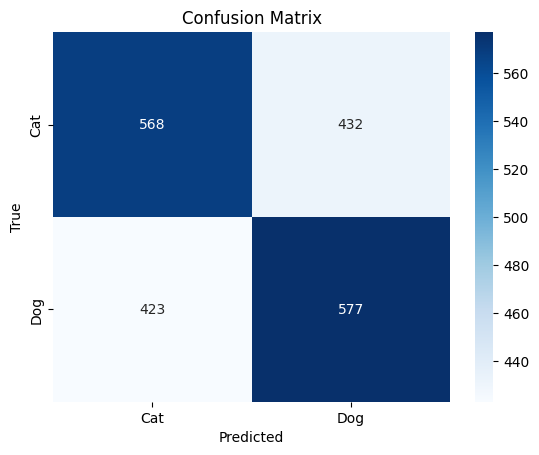

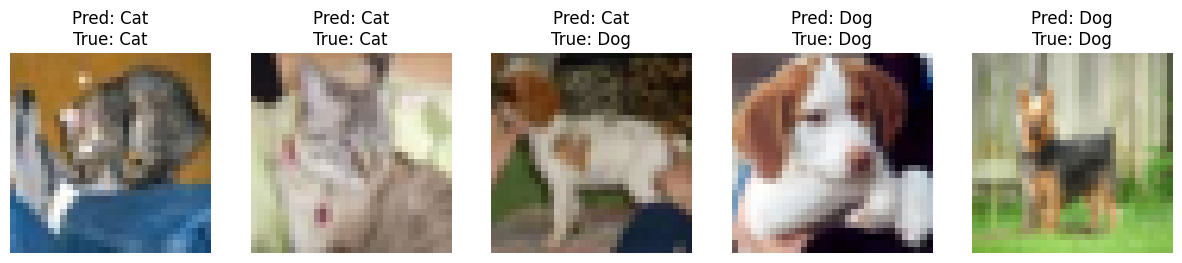

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Завантажуємо датасет CIFAR-10
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Перетворюємо мітки в одномірний масив
train_labels = train_labels.reshape(-1)
test_labels = test_labels.reshape(-1)

# Вибираємо тільки зображення котів (мітка 3) і собак (мітка 5)
train_images = train_images[(train_labels == 3) | (train_labels == 5)]
train_labels = train_labels[(train_labels == 3) | (train_labels == 5)]
test_images = test_images[(test_labels == 3) | (test_labels == 5)]
test_labels = test_labels[(test_labels == 3) | (test_labels == 5)]

# Масштабування зображень до діапазону [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

# Переводимо мітки в бінарні (0 - кіт, 1 - собака)
train_labels = np.where(train_labels == 3, 0, 1)
test_labels = np.where(test_labels == 3, 0, 1)


# Завантажуємо попередньо натреновану модель MobileNetV2 без верхнього шару
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Заморожуємо всі шари базової моделі, щоб не тренувати їх під час початкового етапу
base_model.trainable = False

# Створюємо модель
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Агрегація простору для зменшення розмірів
    layers.Dense(128, activation='relu'),  # Повнозв'язаний шар для класифікації
    layers.Dense(1, activation='sigmoid')  # Оскільки у нас 2 класи: кіт (0) та собака (1)
])

# Компиляція моделі
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Втрата для двокласової класифікації
              metrics=['accuracy'])

# Тренування моделі
history = model.fit(train_images, train_labels, epochs=25, batch_size=32, validation_data=(test_images, test_labels))

# Оцінка моделі після початкового тренування
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

# Fine-tuning: розморожуємо деякі шари базової моделі для донавчання
base_model.trainable = True
for layer in base_model.layers[:100]:  # Розморожуємо лише перші 100 шарів
    layer.trainable = False

# Перекомпілюємо модель після fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Зменшення швидкості навчання для fine-tuning
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Донавчання моделі
history_finetune = model.fit(train_images, train_labels, epochs=15, batch_size=32, validation_data=(test_images, test_labels))

# Оцінка моделі після fine-tuning
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Fine-tuned Test accuracy: {test_accuracy * 100:.2f}%')

# Побудова матриці похибок
y_pred = (model.predict(test_images) > 0.5).astype("int32")  # Перетворення ймовірностей в бінарні значення
cm = confusion_matrix(test_labels, y_pred)

# Візуалізація матриці похибок
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Візуалізація результатів: зображення з тестового набору з передбаченими класами
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    ax = axes[i]
    ax.imshow(test_images[i])
    pred_label = "Dog" if y_pred[i] == 1 else "Cat"
    true_label = "Dog" if test_labels[i] == 1 else "Cat"
    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}")
    ax.axis("off")
plt.show()


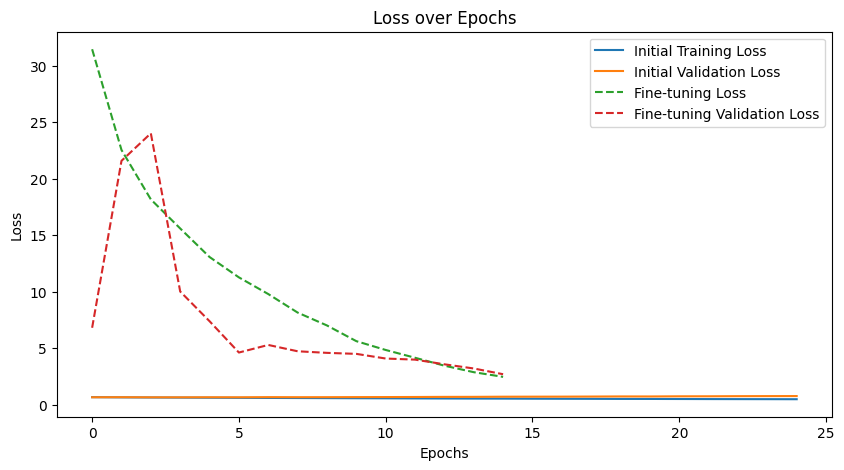

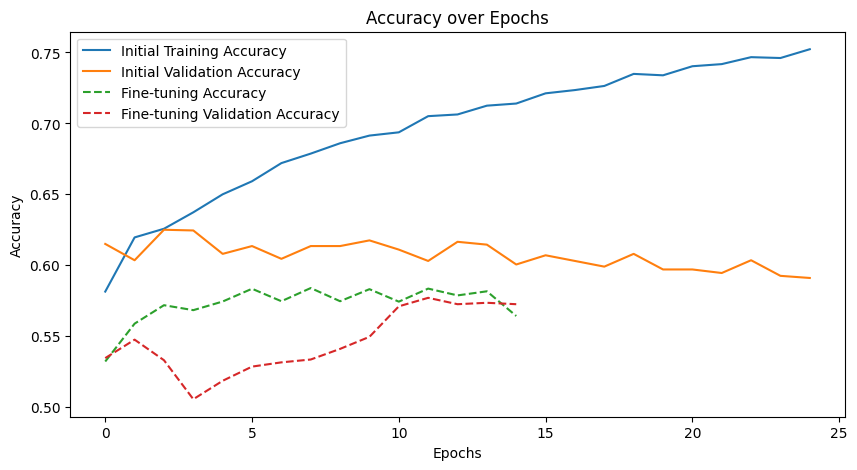

In [7]:
# Отримуємо дані про втрати і точність
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Дані для fine-tuning
fine_tune_loss = history_finetune.history['loss']
fine_tune_val_loss = history_finetune.history['val_loss']
fine_tune_accuracy = history_finetune.history['accuracy']
fine_tune_val_accuracy = history_finetune.history['val_accuracy']

# Епохи для кожного етапу
epochs_initial = range(len(loss))
epochs_finetune = range(len(fine_tune_loss))

# Побудова графіків втрат
plt.figure(figsize=(10, 5))
plt.plot(epochs_initial, loss, label='Initial Training Loss')
plt.plot(epochs_initial, val_loss, label='Initial Validation Loss')
plt.plot(epochs_finetune, fine_tune_loss, label='Fine-tuning Loss', linestyle='--')
plt.plot(epochs_finetune, fine_tune_val_loss, label='Fine-tuning Validation Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Побудова графіків точності
plt.figure(figsize=(10, 5))
plt.plot(epochs_initial, accuracy, label='Initial Training Accuracy')
plt.plot(epochs_initial, val_accuracy, label='Initial Validation Accuracy')
plt.plot(epochs_finetune, fine_tune_accuracy, label='Fine-tuning Accuracy', linestyle='--')
plt.plot(epochs_finetune, fine_tune_val_accuracy, label='Fine-tuning Validation Accuracy', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
